# English to Nepali translation using Transformer Based Model

This notebook builds a basic **Encoder-Decoder** variant of the Transformer architecture from scratch (Multi-Head Attention, Scaled Dot-Product Attention and Causal Masking included) in TensorFlow.

It serves to understand how each part of the Transformer works and how they all fit together.

The Transformer is then tested on a simple seq2seq task : **translating sentences from English to Nepali**.   

In [1]:
import os
import pandas as pd
import random
import matplotlib.pyplot as plt
import keras
import tensorflow as tf
import string
import re
import numpy as np

In [2]:
print(f"Tensor Flow Version: {tf.__version__}")

Tensor Flow Version: 2.10.1


In [3]:
gpu = tf.config.list_physical_devices('GPU')
print(f"GPU: {gpu}")

GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
print(f"current working directory: {os.getcwd()}")

current working directory: C:\Users\Leapfrog\Downloads


# Preparing the data

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Reading the data</b></p>
</div>

In [5]:
# Get the file path
file_path = os.path.join(os.getcwd(), r"C:\Users\Leapfrog\Desktop\Final Anuvadak\dataset_latest.csv")

# Reading txt file
# with open(file_path, "rb") as f:
#     data=f.read()

# Decode the bytes object to a string, assuming UTF-8 encoding
# data = data.decode('utf-8')  # This line is added to decode the bytes object

# Creating a DataFrame
# df = pd.DataFrame([line.split('\t')[:2] for line in data.strip().split('\n')], columns=["English words/sentences", "Nepali words/sentences"])

df = pd.read_csv(file_path, encoding='utf-8')

df.rename(columns={"source": "English words/sentences", "target": "Nepali words/sentences"}, inplace=True)

# Printing the dataframe
df.sample(10)


,English words/sentences,Nepali words/sentences
26606,If I fought with animals at Ephesus for human ...,यदि खाली मानवताको कारणले मैले एफिससमा जंगली जा...
10481,"Let the proud be disappointed, for they have o...",मानिसहरू ज-जसले तिनीहरू मभन्दा असल हुँ भनेर सो...
36039,But the strength of the translation and the sk...,तर अनुवादको सशक्तता तथा साहित्यिक अनुवादको सीप...
130069,People of this kind of microscopic illness and...,यस किसिमको भष्म धातुक्षयका बिरामी तथा दुर्बलता...
66250,Windows Scheme (With Win Key),विण्डोज योजना (विन कुञ्जीसँग)
142925,Insert Label Ranges,लेबल फैलावट जोड
103645,"Therefore , no development , research and diss...","त्यसैले , सिमलत्तरुल सम्बन्धी कुनै बिकास , अनु..."
7142,"also the firstborn of our sons, and of our liv...",“व्यवस्थामा लेखे झैं हामी पनि हाम्रा पहिलो जन्...
46256,Click here to remove the selected file type.,चयन गरेको फाइल प्रकार हटाउन यहाँ क्लिक गर्नुहो...
145898,Try to Reattempt a Download,डाउनलोडका निम्ति फेरि प्रयास गर्नुहोस्


In [6]:
df["source"] = df["English words/sentences"]

# let's add an initial “seed” token ([start]) and a stop token ([end]) to each target sentence.
df["target"] = df["Nepali words/sentences"].apply(lambda x: "[start] " + x + " [end]")
df = df.drop(["English words/sentences", "Nepali words/sentences"], axis=1)

# display a few random samples
df.sample(10)

,source,target
110412,"First World War, DDT prayogadosro poisonous in...",[start] सर्वप्रथम डीडीटीको प्रयोगदोस्रो विश्वय...
18587,In the first day there shall be to you a holy ...,[start] यो पवित्र चाडको पहिलो र अन्तिम दिनमा प...
40590,Agfa Pan 100: Simulate the Agfa Pan black and ...,[start] तटस्थ श्यामश्वेतश्यामश्वेत तटस्थ फिल्म...
127844,She says - ' Because of not being educated acc...,[start] उनी भन्छिन् – ‘ पढाइअनुसारको मान्यता न...
49104,Create a new unit from scratch,[start] स्क्रयाचबाट नयाँ एकाइ सिर्जना गर्नुहोस...
107789,What does this benefit me ?,[start] यसले मलाई के लाभ हुन्छ र ? [end]
116424,The ground - Part overworked.,[start] ती भू-भाग जोतिए । [end]
124786,Lascar of the women who are increasingly blowi...,[start] बागलुङ सखारै उकालिदै गरेका महिलाको लस्...
100327,Real Sukkur residents do not know that land is...,[start] वास्तविक सुकुम्वासीलाई त जग्गा पाईन्छ ...
90156,Editor text formating,[start] सम्पादकको पाठ ढाँचाबद्ध गर्दैछ [end]


In [7]:
# df = df.sample(100000)

print(f"Total dataset: {len(df)}")

Total dataset: 146901


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Shuffling the data and splitting it into train, validation, and test sets</b></p>
</div>

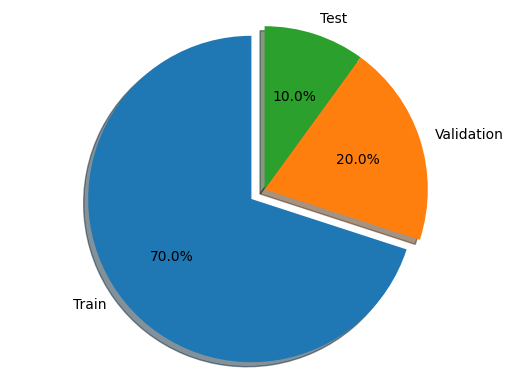

In [8]:
# shuffle the data
df = df.sample(frac=1).reset_index(drop=True)

# split the data into train, validation, and test sets
train_size = int(len(df) * 0.7)
val_size = int(len(df) * 0.2)
test_size = int(len(df) * 0.1)

train_df = df[:train_size]
val_df = df[train_size:train_size+val_size]
test_df = df[train_size+val_size:]

# display the data sets representations using a pie chart just to see the distribution of the data
labels = "Train", "Validation", "Test"
sizes = [len(train_df), len(val_df), len(test_df)]
explode = (0.1, 0, 0)
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct="%1.1f%%", shadow=True, startangle=90)
ax1.axis("equal")
plt.show()


<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Standardizing, tokenizing and indexing the data</b></p>
</div>

First, we need to parse our raw text data and vectorize it.

To keep things simple, we will first limit our vocabulary using the **max_tokens** parameter. We will also limit the length of each sentence using the **sequence_length** parameter.

Each sentence will be standardized, tokenized by word, and then indexed by token.

This will result in a batch of vectors of tokens, stored in a **2D** matrix of shape [(batch_size, **sequence_length**)].

In [9]:
max_tokens = 2500
sequence_length = 30

# define a custom standardization function that convert to lowercase and strips all punctuations except "[" and "]" (so we can tell apart "start" from "[start]").
strip_chars = string.punctuation
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)
    return tf.strings.regex_replace(
        lowercase, f"[{re.escape(strip_chars)}]", "")

# tokenize the data using our custom standardization function
source_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length,
)
target_vectorization = keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=sequence_length + 1, # add +1 token to our target sentences since they'll be shifted right by 1 during training
    standardize=custom_standardization,
)

def sanitize_text(text):
    return text.encode('utf-8', 'ignore').decode('utf-8', 'ignore')



# index all tokens in the source and target sentences
train_source_texts = train_df["source"].astype(str).values
train_target_texts = train_df["target"].apply(sanitize_text).astype(str).values
source_vectorization.adapt(train_source_texts)
target_vectorization.adapt(train_target_texts)

In [10]:
print(train_target_texts[:2])

['[start] @LuisCarlos आफ्नो बाईकमा छन्, तर साँझ ५:३० देखि उनी संपर्कमा छैनन् र  [end]'
 '[start] सबै छविहरू अधिलेखन गर्नुहोस् [end]']


In [11]:

# display a random sample before and after vectorization just to test the vectorization
random_sample = random.randint(0, len(train_df))

In [12]:
print(random_sample)

67944


In [13]:
# display the decoding of the vectorized text (from vector back to text) just to test the vectorization
source_decoded_text = ""
for i in range(len(source_vectorization(train_source_texts[random_sample]))):
    source_decoded_text += source_vectorization.get_vocabulary()[source_vectorization(train_source_texts[random_sample])[i]] + ' '
print("Source decoded texts (one random sample):", source_decoded_text)

Source decoded texts (one random sample): [UNK] to                             


In [14]:
print("Source texts (one random sample):", train_source_texts[random_sample])

Source texts (one random sample): Redirecting to...


In [15]:
print("Target texts (one random sample):", train_target_texts[random_sample])

Target texts (one random sample): [start] लाई पुननिर्देशन गरिँदैछ... [end]


In [16]:
print("Source vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))

Source vectors (one random sample): tf.Tensor([1 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(30,), dtype=int64)


In [17]:
print("Target vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))

Target vectors (one random sample): tf.Tensor(
[  2 271   1   1   3   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0], shape=(31,), dtype=int64)


In [18]:
random_sample = random.randint(0, len(train_target_texts) - 1)  # Ensure random_sample is valid
print(random_sample)

8785


In [19]:
target_decoded_text = ""
random_sample = random.randint(0, len(train_target_texts) - 1)  # Ensure random_sample is valid
print(random_sample)

36531


In [20]:
print(len(target_vectorization(train_target_texts[random_sample])))

31


In [21]:
print(train_target_texts[31])

[start] तर रिसर्च सेन्टरको बोर्ड राखेका साना क्लिनिकले भने कुनै अध्ययन – अनुसन्धान गर्न सकेका छैनन् । [end]


In [22]:
print(random_sample)

36531


In [23]:
vocab_index = target_vectorization(train_target_texts[77065])[1]
print(vocab_index)

tf.Tensor(68, shape=(), dtype=int64)


In [24]:
def has_surrogates(s):
    return any(0xD800 <= ord(c) <= 0xDFFF for c in s)

invalid_texts = [text for text in train_df["target"] if has_surrogates(text)]
if invalid_texts:
    print("Found texts with surrogates. Clean the data.")


In [1]:
target_decoded_text = ""
random_sample = random.randint(0, len(train_target_texts) - 1)  # Ensure random_sample is valid

for i in range(len(target_vectorization(train_target_texts[random_sample]))):
    vocab_index = target_vectorization(train_target_texts[random_sample])[i]
    target_decoded_text += target_vectorization.get_vocabulary()[vocab_index] + " "

print("Target decoded texts (one random sample):", target_decoded_text)

NameError: name 'random' is not defined

In [ ]:
import random

# Ensure random_sample is valid
random_sample = random.randint(0, len(train_target_texts) - 1)

# Vectorize the randomly selected target text
vectorized_text = target_vectorization(train_target_texts[random_sample])

# Decode the vectorized text
target_decoded_text = ""
vocabulary = target_vectorization.get_vocabulary()

for vocab_index in vectorized_text:
    try:
        word = vocabulary[vocab_index]
        if isinstance(word, bytes):
            word = word.decode("utf-8", errors="replace")  # Replace invalid characters
        target_decoded_text += word + " "
    except UnicodeError as e:
        print(f"Error decoding vocabulary entry at index {vocab_index}: {e}")
        target_decoded_text += "[UNK] "  # Use a placeholder for corrupted entries

# Remove the trailing space
target_decoded_text = target_decoded_text.strip()

print("Target decoded texts (one random sample):", target_decoded_text)

In [ ]:
# display the shape of our vectorized data
train_source_vectors = source_vectorization(train_source_texts)
train_target_vectors = target_vectorization(train_target_texts)
print("Source vectors (shape):", train_source_vectors.shape)
print("Target vectors (shape):", train_target_vectors.shape)

# Building the Transformer

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Positional Embedding</b></p>
</div>

In order for our Transformer to be aware of the word order in each sentence, we must add some positional information to the data. **Words must become position-aware.**

First, each token in our vectors will be embedded in a low-dimensional vector (the dimensionality of the embedding space is defined by the **embedding_size** parameter).

Secondly, position information (info on where each word stands in the sentence) will be created and added to the embeddings.

This will result in a batch of vectors of positional embeddings, stored in a **3D** matrix of shape [(batch_size, sequence_length, **embedding_size**)].

In [ ]:
class PositionalEmbedding(keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = keras.layers.Embedding(input_dim=input_dim, output_dim=output_dim) # token embedding layer
        self.position_embeddings = keras.layers.Embedding(input_dim=sequence_length, output_dim=output_dim) # position embedding layer
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        embedded_tokens = self.token_embeddings(inputs) # embed the tokens
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1) # create the positional information
        embedded_positions = self.position_embeddings(positions) # embed the positions
        return embedded_tokens + embedded_positions # add the token and position embeddings to create the positional embeddings

    def compute_mask(self, inputs, mask=None):
        return keras.ops.not_equal(inputs, 0)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "input_dim": self.input_dim,
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
        })
        return config

In [ ]:
# display a random sample before and after embbeding just to test our class

embed_dim = 256

with tf.device('gpu:0'):
    train_source_embedded = PositionalEmbedding(
        sequence_length=sequence_length,
        input_dim=max_tokens,
        output_dim=embed_dim,
        name="source_embedding",
    ) (train_source_vectors)

    train_target_embedded = PositionalEmbedding(
        sequence_length=sequence_length,
        input_dim=max_tokens,
        output_dim=embed_dim,
        name="target_embedding",
    ) (train_source_vectors)

    random_sample = random.randint(0, len(train_df))
    print("Source texts (one random sample):", train_source_texts[random_sample])
    print("\nTarget texts (one random sample):", train_target_texts[random_sample])
    print("\nSource vectors (one random sample):", source_vectorization(train_source_texts[random_sample]))
    print("\nTarget vectors (one random sample):", target_vectorization(train_target_texts[random_sample]))
    print("\nSource embedded vectors (one random sample):", train_source_embedded[random_sample])
    print("\nTarget embedded vectors (one random sample):", train_target_embedded[random_sample])

In [ ]:
# display the shape of our embedded data just to test the class
print("Source embedded vectors (shape):", train_source_embedded.shape)
print("Target embedded vectors (shape):", train_target_embedded.shape)

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Attention mechanism</b></p>
</div>

The goal here is to make each of our words (positional embeddings at this point) aware of the other words surrounding them. **Words must become context-aware.**

The implementation of the Attention mechanism involves the following 3 steps :

- Causal Masking
- Scaled Dot-Product Attention
- Multi-Head Attention

In practice, we could just use **keras.layers.MultiHeadAttention** instead of building it from scratch, but let's do it anyway!

<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Causal Masking</b></p>
</div>


Since our words will now be context-aware (aware of words before **and** after them in the sentence), we need a way to mask those *after-words* when needed be (i.e. during training).

In [ ]:
def shape_list(x):
    """Deal with dynamic shape in tensorflow cleanly."""
    static = x.shape.as_list()
    dynamic = tf.shape(x)
    return [dynamic[i] if s is None else s for i, s in enumerate(static)]

def attention_mask(nd, ns, *, dtype):
    """1's in the lower triangle, counting from the lower right corner.
    Same as tf.matrix_band_part(tf.ones([nd, ns]), -1, ns-nd), but doesn't produce garbage on TPUs.
    """
    i = tf.range(nd)[:,None]
    j = tf.range(ns)
    m = i >= j - ns + nd
    return tf.cast(m, dtype)

def mask_attn_weights(w):
    # w has shape [batch, heads, dst_sequence, src_sequence], where information flows from src to dst.
    _, _, nd, ns = shape_list(w)
    b = attention_mask(nd, ns, dtype=w.dtype)
    b = tf.reshape(b, [1, 1, nd, ns])
    w = w*b - tf.cast(1e10, w.dtype)*(1-b)
    return w

In [ ]:
# display the causal masking of a random tensor just to test the function
random_tensor = tf.random.uniform(shape=(1, 1, 5, 5), minval=0, maxval=1, dtype=tf.float32)
print("Masked attention weights:", mask_attn_weights(random_tensor))

<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Scaled Dot-Product Attention</b></p>
</div>

This function is what makes our words context-aware.

We want to compare each word with every other words around them and take note of how *related* they are. Technically, this process can be described as "mapping a query and a set of key-value pairs to an output". It can be summarized as follows :
- We take a **Q**uery of elements.
- For each element in the **Q**uery, we score how much that element is related to every **K**ey (This is done using a compatibility function : MatMul). If needed be, Causal Masking will be applied here.
- Then, we use these relationship scores to weight a sum of **V**alues, which will be our new context-aware representations.


In [ ]:
def scaled_dot_product_attention(q, k, v, use_causal_mask=False):
    d_k = tf.cast(tf.shape(k)[-1], tf.float32)
    scores = tf.matmul(q, k, transpose_b=True) # Matmul of Q and K
    scaled_scores = scores / tf.math.sqrt(d_k) # Scale
    if use_causal_mask:
        scaled_scores = mask_attn_weights(scaled_scores) # Mask (opt.)
    weights = tf.nn.softmax(scaled_scores, axis=-1) # SoftMax
    output = tf.matmul(weights, v) # Matmul of SoftMax and V
    return output

In [ ]:
# display the shape of our attention output just to test the function

input = train_source_embedded
input = tf.expand_dims(input, axis=1)
print("Scaled dot product attention (shape):", scaled_dot_product_attention(input, input, input, use_causal_mask=True).shape)

<div style="color:#fff; display:fill; border-width:1px; border-color:#000; font-size:125%;">
    <p style="border-style:solid; border-radius:8px; background-color:#fff; padding: 8px 12px 8px 12px; color:#000;"><b>Multi-Head Attention</b></p>
</div>

Multi-head attention was introduced in [Attention is all you need](https://arxiv.org/abs/1706.03762) and is wayyy to technical for me to try and explain here. But basically, it allows for multiple Scaled Dot-Production Attention functions to be run in parallel.
    

In [ ]:
class MultiHeadAttention(keras.layers.Layer):
    def __init__(self, embed_dim, h, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.h = h
        if embed_dim % h != 0:
            raise ValueError(
                f"dimension of the embedding space = {embed_dim} should be divisible by number of heads = {h}"
            )
        self.q_linear = keras.layers.Dense(embed_dim)
        self.k_linear = keras.layers.Dense(embed_dim)
        self.v_linear = keras.layers.Dense(embed_dim)
        self.concat_linear = keras.layers.Dense(embed_dim)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, shape=(batch_size, -1, self.h, self.embed_dim // self.h))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def concat_heads(self, x, batch_size):
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        return tf.reshape(x, (batch_size, -1, self.embed_dim))

    def call(self, q, k, v, use_causal_mask=False):
        batch_size = tf.shape(k)[0]
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)
        q = self.split_heads(q, batch_size)
        k = self.split_heads(k, batch_size)
        v = self.split_heads(v, batch_size)
        attention = scaled_dot_product_attention(q, k, v, use_causal_mask)
        concat = self.concat_heads(attention, batch_size)
        concat = self.concat_linear(concat)
        return concat

    def get_config(self):
        config = super(MultiHeadAttention, self).get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "h": self.h,
        })
        return config

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Encoder</b></p>
</div>

The role of the Encoder is to process the source sentence. Here, no Causal Masking is needed : information is allowed to flow in both directions (words can be aware of words before **and** after them in the sentence).

The Encoder's a pretty generic module that ingests a sentence and learns to turn it into a more useful representation. It can also be used by itself (without the Decoder) for Natural Language Understanding (NLU) tasks like Classification or Named Entity Recognition (NER).

In the Encoder's Multi-Head Self-Attention layer ([Global self-attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_global_self_attention_layer)), the **Source Vectors Embeddings** are being passed to all three parameters : **Q**uery, **K**ey, and **V**alue.

In [ ]:
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.layer_norm_1 = keras.layers.LayerNormalization()
        self.layer_norm_2 = keras.layers.LayerNormalization()
        self.global_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = keras.Sequential(
            [keras.layers.Dense(dense_dim, activation="relu"),
             keras.layers.Dense(embed_dim),]
        )

    def call(self, x):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.global_self_attention(q=x, k=x, v=x))
        x = self.layer_norm_2(x + self.feed_forward(x))
        return x

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>The Decoder</b></p>
</div>

The role of the Decoder is to look at the target sentence so far and predict the next word in that sentence.

Contrary to the Encoder, the Decoder is made of two Attention layers. The first Attention layer does a similar job as the Encoder's sole Attention layer, with the important distinction that here, Causal Masking is enabled because, to correctly train our Transformer to predict the next word based on the current word and the previous words in the sentence, we need to mask the *after-words*. Meanwhile, The second Attention layer is much more straight-forward and basically just acts as a bridge that connects the Encoder to the Decoder.

In the Decoder's first Attention layer, the Masked Multi-Head Self-Attention layer ([Causal self-attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_causal_self_attention_layer)), the **Target Vectors Embeddings** are being passed to all three parameters : **Q**uery, **K**ey, and **V**alue. Like mentionned above, Causal Masking is enabled in this layer.

In the Decoder's second Attention layer, the Encoder-Decoder Attention layer ([Cross attention layer](https://www.tensorflow.org/text/tutorials/transformer#the_cross_attention_layer)), the **outputs of the Encoder** are being passed to the **K**ey and **V**alue parameters, with the **outputs of the Decoder's Masked Multi-Head Self-Attention layer** being passed to the **Q**uery parameter.


In [ ]:
class TransformerDecoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.causal_self_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.cross_attention = MultiHeadAttention(embed_dim=embed_dim, h=num_heads)
        self.feed_forward = keras.Sequential(
            [keras.layers.Dense(dense_dim, activation="relu"),
             keras.layers.Dense(embed_dim),]
        )
        self.layer_norm_1 = keras.layers.LayerNormalization()
        self.layer_norm_2 = keras.layers.LayerNormalization()
        self.layer_norm_3 = keras.layers.LayerNormalization()

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
        })
        return config

    def call(self, x, context):
        # Post layer normalization + residual connections
        x = self.layer_norm_1(x + self.causal_self_attention(q=x, k=x, v=x, use_causal_mask=True))
        x = self.layer_norm_2(x + self.cross_attention(q=x, k=context, v=context))
        x = self.layer_norm_3(x + self.feed_forward(x))
        return x

<div style="color:#000; display:fill; border-radius:8px; background-color:#000; font-size:125%;">
    <p style="padding: 8px 12px 8px 12px; color:#fff;"><b>Putting it all together</b></p>
</div>

We  turn our data into a *tf.data pipeline* that returns a tuple (Inputs, Outputs) where Inputs is a dict with two keys : **encoder_inputs** (the source sentence) and **decoder_inputs** (the target sentence), and Outputs is a single key : **decoder_outputs** (the target sentence "shifted right").

During training, the fact that our Outputs are offset by one step ahead ("shifted right"), combined with the Causal Masking of the Decoder (Masked Multi-Head Attention layer), ensures that the
predictions for position *i* can depend only on the known outputs at positions less than *i* (no *after-words* visible).

During inference, we'll generate one target word at a time and then feed it back into the Decoder so that it can predict the next word. And so on.

In [ ]:
batch_size = 64

def format_dataset(source, target):
    source_vectors = source_vectorization(source)
    target_vectors = target_vectorization(target)
    return ({
        "source": source_vectors, # encoder_inputs
        "target": target_vectors[:, :-1], # decoder_inputs (truncate by 1 to keep it at the same length as decoder_outputs, which is shifted right by 1).
    }, target_vectors[:, 1:]) # decoder_outputs

def make_dataset(df):
    dataset = tf.data.Dataset.from_tensor_slices((df["source"].astype("str").values, df["target"].astype("str").values))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)
    return dataset.shuffle(2048).prefetch(16).cache()

train_ds = make_dataset(train_df)
val_ds = make_dataset(val_df)

In [ ]:
# display the shape of the first batch of data in the dataset just to see what it looks like
for batch in train_ds.take(1):
    print("Encoder Inputs:", batch[0]["source"].shape)
    print("Decoder Inputs:", batch[0]["target"].shape)
    print("Decoder Outputs:", batch[1].shape)

In [ ]:
embed_dim = 512 # dimension of the embedding space
dense_dim = 2048 # dimension of the feed forward network (a rule of thumb is to use 4 times the size of the embeddings)
num_heads = 8

with tf.device('gpu:0'):
  # the transformer body
  encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="source")
  x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)
  encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
  decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="target")
  x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)
  x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)

  # the transformer body
  # encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="source")
  # x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)

  # # Add more encoder layers
  # num_encoder_layers = 3  # You can change this number
  # for _ in range(num_encoder_layers):
  #     x = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)
  # encoder_outputs = x  # Output of the last encoder layer

  # decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="target")
  # x = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)

  # # Add more decoder layers
  # num_decoder_layers = 3  # You can change this number
  # for _ in range(num_decoder_layers):
  #     x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs)

  # the transformer head
  x = keras.layers.Dropout(0.5)(x)
  decoder_outputs = keras.layers.Dense(max_tokens, activation="softmax")(x)

  transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

In [ ]:
# # Define hyperparameters
# embed_dim = 512  # Dimension of the embedding space
# dense_dim = 2048  # Dimension of the feedforward network
# num_heads = 8  # Number of attention heads
# num_encoder_layers = 6  # Number of encoder layers
# num_decoder_layers = 6  # Number of decoder layers
# dropout_rate = 0.5  # Dropout rate

# # Inputs for encoder and decoder
# encoder_inputs = keras.Input(shape=(None,), dtype="int64", name="source")
# decoder_inputs = keras.Input(shape=(None,), dtype="int64", name="target")

# # Positional embedding
# x_encoder = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(encoder_inputs)
# x_decoder = PositionalEmbedding(sequence_length, max_tokens, embed_dim)(decoder_inputs)

# # Encoder stack
# for _ in range(num_encoder_layers):
#     x_encoder = TransformerEncoder(embed_dim, dense_dim, num_heads)(x_encoder)
# encoder_outputs = x_encoder

# # Decoder stack
# for _ in range(num_decoder_layers):
#     x_decoder = TransformerDecoder(embed_dim, dense_dim, num_heads)(x_decoder, encoder_outputs)

# # Output head
# x_decoder = keras.layers.Dropout(dropout_rate)(x_decoder)
# decoder_outputs = keras.layers.Dense(max_tokens, activation="softmax")(x_decoder)

# # Define the complete Transformer model
# transformer = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

# # Summary of the model
# transformer.summary()


# Training the Transformer

In [ ]:
# import warnings
# warnings.filterwarnings("ignore")

# transformer.compile(
#     optimizer="rmsprop",
#     loss="sparse_categorical_crossentropy",
#     metrics=["accuracy"])

# EPOCHS = 15
# # checkpoint_filepath = '/tmp/checkpoint.weights.h5'
# callbacks_list = [
#     keras.callbacks.ReduceLROnPlateau(
#         monitor='val_loss',
#         factor=0.01,
#         patience=5,
#     ),
#     keras.callbacks.EarlyStopping(
#         monitor='val_loss',
#         patience=5,
#     ),
#     # keras.callbacks.ModelCheckpoint(
#     #     # filepath=checkpoint_filepath,
#     #     # save_weights_only=True,
#     #     monitor='val_loss',
#     #     mode='min',
#     #     # save_best_only=True
#     # ),
# ]

# history = transformer.fit(train_ds,
#                 epochs=EPOCHS,
#                 callbacks=callbacks_list,
#                 validation_data=val_ds)

# # transformer.load_weights(checkpoint_filepath)

In [ ]:
transformer.summary()

In [ ]:
import warnings
warnings.filterwarnings("ignore")

checkpoint_filepath = os.path.join(os.getcwd(), 'drive/My Drive/Datasets/checkpoint_1.weights.h5')

# Compile the model with specified learning rate
transformer.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

EPOCHS = 10

# Define callbacks
callbacks_list = [
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.1,
        patience=5,  # Reduce LR if no improvement for 5 epochs
        verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=5,  # Stop training if no improvement for 5 epochs
        verbose=1,
        restore_best_weights=True  # Restore the best weights
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=checkpoint_filepath,
        save_weights_only=True,
        monitor='val_loss',
        mode='min',
        save_best_only=True
    ),
]

# Train the model
with tf.device('gpu:0'):
  history = transformer.fit(
      train_ds,
      epochs=EPOCHS,
      callbacks=callbacks_list,
      validation_data=val_ds
  )


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# history.save('my_model_history.keras')

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))  # Adjust figure size if needed
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
plt.figure(figsize=(10, 5))  # Adjust figure size if needed
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Testing the Transformer

Let's translate a few random test sentences with our newly-trained Transformer.

In [ ]:
target_vocab = target_vectorization.get_vocabulary()
target_index_lookup = dict(zip(range(len(target_vocab)), target_vocab))
max_decoded_sentence_length = 30

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"
    for i in range(max_decoded_sentence_length):
        tokenized_target_sentence = target_vectorization(
            [decoded_sentence])[:, :-1]
        predictions = transformer(
            [tokenized_input_sentence, tokenized_target_sentence])
        sampled_token_index = np.argmax(predictions[0, i, :])
        sampled_token = target_index_lookup[sampled_token_index]
        decoded_sentence += " " + sampled_token
        if sampled_token == "[end]":
            break
    return decoded_sentence


# random_index = np.random.randint(0, len(test_df))
# input_sentence = test_df["source"].iloc[random_index]
# print(input_sentence)
# print(decode_sequence(input_sentence))

In [ ]:
example = "I live in Kathmandu."
translation = decode_sequence(example)
print(f"'{example}' translated to - '{translation}'")

In [ ]:
example = "The translation was correct."
translation = decode_sequence(example)
print(f"'{example}' translated to - '{translation}'")

In [ ]:
example = "We completed the project"
translation = decode_sequence(example)
print(f"'{example}' translated to - '{translation}'")

In [ ]:
example = "The result was good."
translation = decode_sequence(example)
print(f"'{example}' translated to - '{translation}'")

# Evaluating the model using BLEU (Bilingual Evaluation Understandy)

In [ ]:
!pip install nltk
import nltk
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

In [ ]:
import numpy as np

from nltk.translate.bleu_score import sentence_bleu

input_sentence, translated_sentence = test_df.iloc[np.random.randint(0, len(test_df))]

reference = translated_sentence.split()
hypothesis = decode_sequence(input_sentence).split()

BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis, weights = (0.5, 0.5))

print('BLEU score -> {}'.format(BLEUscore))